<a href="https://colab.research.google.com/github/BryanMed/Sequences-Time-Series-and-Prediction/blob/master/mlp_univariateWeatherForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilayer perceptron in time series (univariate) forecasting
Dado que aún estoy aprendiendo acerca del forecasting en series temporales, traté de utilizar el [ejemplo propuesto por tensorflow](https://www.tensorflow.org/tutorials/structured_data/time_series?hl=es_419), sin embargo, la manera en la que preparan los datos para alimentar la red me pareció un poco complicado, así que apliqué mis conocimientos adquiridos en el curso que estoy realizando. Por ello, en lugar de usar una red LSTM (y para variarle), usaré una multilayer perceptron.

In [0]:
! pip install tf-nightly-2.0-preview

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os

Datos de las condiciones climáticas del 2009 al 2016

In [0]:
zip_path = tf.keras.utils.get_file(
  origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
  fname='jena_climate_2009_2016.csv.zip',
  extract=True)

csv_path, _ = os.path.splitext(zip_path)

In [6]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Vamos a trabajar primeramente con una serie temporal univariada, así que solamente usaremos las variaciones de temperatura.

In [7]:
temperatura = df['T (degC)']
temperatura.index = df['Date Time']
temperatura.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

Dividimos los datos en entrenamiento y validación

In [0]:
TRAIN_SPLIT = 300000
#para poder reproducir los resultados 
tf.random.set_seed(13)

#variable solo para plotting
time_numbers = range(len(temperatura.index))

time_train = temperatura.index[:TRAIN_SPLIT]
temperatura_train = temperatura.values[:TRAIN_SPLIT]

time_valid = temperatura.index[TRAIN_SPLIT:]
temperatura_valid = temperatura.values[TRAIN_SPLIT:]

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


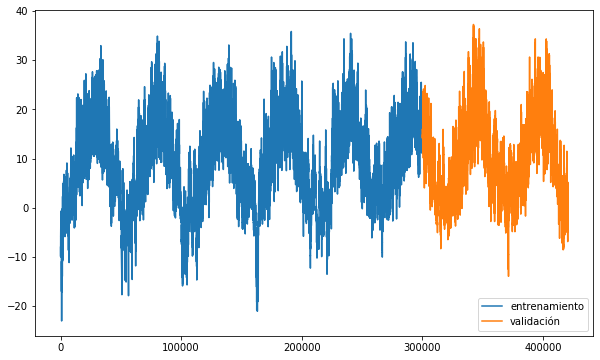

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(time_numbers[:TRAIN_SPLIT], temperatura_train)
plt.plot(time_numbers[TRAIN_SPLIT:], temperatura_valid)
plt.legend(('entrenamiento', 'validación'))
plt.show()

Vamos a estandarizar los datos para que nuestra red neuronal tenga un mejor performance. $$Datos\_estandarizados = (datos - mean(train\_data))/std(train\_data)$$

In [0]:
temp_train_mean = np.mean(temperatura_train)
temp_train_std = np.std(temperatura_train)

temp_estandarizada = (temperatura.values - temp_train_mean)/temp_train_std

Preparamos los datos de entrenamiento para que podamos utilizarlo de manera adecuada en nuestra red que crearemos en tensorflow. Para ello, dividiremos los datos en ventanas de 20 valores, y el valor a predecir será el 21avo

In [0]:
WINDOW_SIZE = 20 #ventana en la que miraremos nuestros datos al pasado
BATCH_SIZE = 256
BUFFER_SIZE = 10000

dataset = tf.data.Dataset.from_tensor_slices(temperatura_train)
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))
dataset = dataset.shuffle(BUFFER_SIZE).map(lambda window: (window[:-1], window[-1]))

In [12]:
for x, y in dataset.take(1):
  print('ventana:', x.numpy(), " ---> label:", y.numpy())

ventana: [-0.1  -0.04  0.    0.03  0.05  0.12  0.12 -0.04 -0.02  0.08 -0.05 -0.17
 -0.14 -0.01 -0.04 -0.13 -0.01  0.01  0.16 -0.09]  ---> label: -0.26


Todo bien hasta entonces, creé unos datos cuya ventana son de 20, y el valor a predecir es el siguiente (el 21), sin embargo no sabía que onda  con el batching (porque la documentación de tf no está tan chida) entonces encontré [esta respuesta de stackoverflow](https://stackoverflow.com/questions/41175401/what-is-a-batch-in-tensorflow) y me ayudó a entender que el batching es un parámetro que nos permite "paralelizar" el entrenamiento

In [0]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1).repeat()

Ahora bien, para saber bien que está pasando, pues básicamente nos está agrupando los datos en batches (_lotes_) de a 256, con elementos de 20. En otras palabras nos agrupa el dataset en grupos que contienen 256 ventanas (20 elementos).



In [14]:
for x, y in dataset.take(1):
  print(x.numpy().shape, y.numpy().shape)#tamaño después del batching
  print(x[0].numpy(), y[0].numpy())#veerifico la estructura del primer elemento
  print(x[0, 19].numpy, y[0].numpy())#igual, verifico el último elemento de la primera ventana y veo que es similar al valor a predecir.


(256, 20) (256,)
[-3.84 -3.88 -3.67 -3.3  -3.34 -3.24 -3.15 -3.07 -2.93 -2.78 -2.76 -2.76
 -2.76 -2.71 -2.67 -2.69 -2.7  -2.64 -2.58 -2.46] -2.33
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float64, numpy=-2.46>> -2.33


Igual, preparamos los datos de validación casi de la misma forma. (excepto lo de revolver "shuffle")

In [0]:
WINDOW_SIZE = 20 #ventana en la que miraremos nuestros datos al pasado
BATCH_SIZE = 256
BUFFER_SIZE = 10000

dataset_val = tf.data.Dataset.from_tensor_slices(temperatura_valid)
dataset_val = dataset_val.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)
dataset_val = dataset_val.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))
dataset_val = dataset_val.map(lambda window: (window[:-1], window[-1]))
dataset_val = dataset_val.batch(BATCH_SIZE).repeat()

In [16]:
for x, y in dataset_val.take(1):
  print(x.numpy().shape, y.numpy().shape)

(256, 20) (256,)


Definimos la arquitectura de la red, en este caso de:
* L1 = 20 entradas
* L2 = 8 neuronas
* L3 = 1 neurona

In [0]:
mlp_model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(8, input_shape=[WINDOW_SIZE], activation='relu'),
  tf.keras.layers.Dense(1)
])

mlp_model.compile(optimizer='adam', loss='mae')

In [18]:
for x, y in dataset.take(1):
  print(mlp_model.predict(x).shape)

(256, 1)


Vamos a entrenar al modelo, debido a que el dataset es muy grande (para ahorrar tiempo), cada época correrá con solo 200 pasos, en lugar de utilizar todos los datos de entrenamiento.

In [19]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

mlp_model.fit(dataset, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
              validation_data=dataset_val, validation_steps=50)



Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 8s 38ms/step - loss: 0.5061 - val_loss: 0.2032
Epoch 2/10
200/200 [==============================] - 7s 35ms/step - loss: 0.3097 - val_loss: 0.1931
Epoch 3/10
200/200 [==============================] - 7s 35ms/step - loss: 0.2758 - val_loss: 0.1912
Epoch 4/10
200/200 [==============================] - 7s 35ms/step - loss: 0.2398 - val_loss: 0.1808
Epoch 5/10
200/200 [==============================] - 7s 34ms/step - loss: 0.2071 - val_loss: 0.1809
Epoch 6/10
200/200 [==============================] - 7s 34ms/step - loss: 0.2384 - val_loss: 0.1805
Epoch 7/10
200/200 [==============================] - 7s 35ms/step - loss: 0.2291 - val_loss: 0.1719
Epoch 8/10
200/200 [==============================] - 7s 35ms/step - loss: 0.2326 - val_loss: 0.1702
Epoch 9/10
200/200 [==============================] - 7s 37ms/step - loss: 0.2290 - val_loss: 0.1717
Epoch 10/10
200/200 [===========================

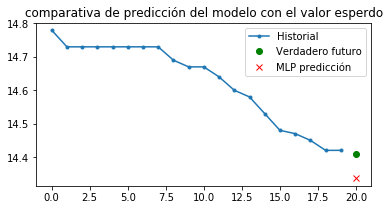

<Figure size 432x288 with 0 Axes>

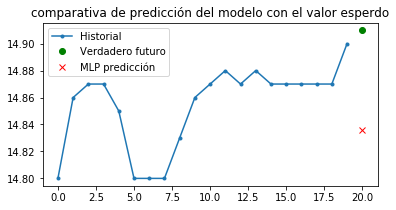

<Figure size 432x288 with 0 Axes>

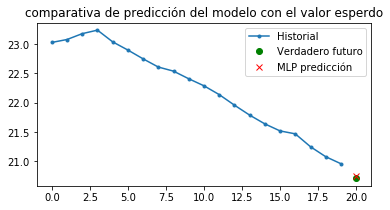

<Figure size 432x288 with 0 Axes>

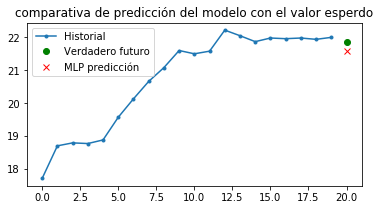

<Figure size 432x288 with 0 Axes>

In [49]:
for x, y in dataset_val.take(4):
  # print(x[0].numpy(), y[0].numpy())
  # print(mlp_model.predict(x)[0])

  plt.figure(figsize=(6,3))
  plt.plot(x[0].numpy(), '.-', label='Historial')
  plt.plot(len(x[0].numpy()), y[0].numpy(), 'go', label='Verdadero futuro')
  plt.plot(len(x[0].numpy()), mlp_model.predict(x)[0], 'rx', label='MLP predicción')
  plt.legend()
  plt.title('comparativa de predicción del modelo con el valor esperdo')
  plt.figure()
